# Part 1 - Starbucks Capstone Challenge

In this notebook contains :
1. Project Overview
2. Problem Understanding
3. Dataset overview
4. Data Understanding and Cleaning

---

# 1. Project Overview

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.


# 2. Problem Understanding

Understanding our customers is the key providing them a good service and sustain a profitable business. To understand them well, we need to pay attention on their purchase behaviour. One way we can collect and analyse their purchasing behaviour through an app, then identify their needs based on demographics.

The Starbucks Udacity Data Scientist Nanodegree Capstone challenge data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Periodically, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). However, some users might not receive any offer during certain weeks.

Using the data, I aim to :

**Part 1 & Part 2**
    1. Gain understanding what types of customer characteristics and demographics are there.
    2. What offer should be sent to each customer based on their demograhics ?
    
**Part 3**
    3. How well can we predict customer response to the offer ?

## Project Metrics :

### Unsupervised Machine Learning Model
An unsupervised machine learning model with K-Means is used to cluster the customers. 

The number of clusters is choosed with 2 metrics : 
1. The [Silhouttee score](https://en.wikipedia.org/wiki/Silhouette_(clustering))
```
The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
```

2. The Inertia / Sum Square Error (SSE) value, can be recognized as a measure of how internally coherent clusters are. We seek to minimize the value.

### Supervised Machine Learning Model
A Supervised Machine learning using regression algorithm is used to predict customers offer completed rate.
The regression metrics are :
1. Mean Squared Error (MSE):
2. Coefficient of Determination (R^2)

# 3. Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2 

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 4. Data Understanding & Cleaning

## 4.1. Portfolio

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


We will perform pre-processing for this dataframe as follow :
- The channels columns require to be one-hot encoded.
- Add offer name rather than only using offer ids for interpretation later on. The offer will be named as `offer_type` _ `difficulty` _ `reward` _ `duration`. For example, `bogo_10_10_7` means offer type of bogo with difficulty of 10 dollar, reward of 10 dollar, and duration for 7 days


In [3]:
#function for cleaning portfolio

def add_portfolio_name(portfolio_df):
    #provide portfolio name instead of id for interpretation later on

    portfolio_df['name'] = portfolio_df.offer_type.astype(str) + "_" + portfolio_df.difficulty.astype(str) +\
                      "_" + portfolio_df.reward.astype(str) + \
                     "_" + portfolio_df.duration.astype(str)
    return portfolio_df

def one_hot_channels(portfolio_df):
    #one hot encoded channels columns
    channels = ['web', 'email', 'mobile', 'social']

    for channel in channels:
        portfolio_df[channel] = portfolio_df.channels.apply(lambda x: channel in x)*1

    #drop channels column
    portfolio_df = portfolio_df.drop('channels', axis=1)
    
    return portfolio_df

def portfolio_preprocessing(portfolio_df):
    # portfolio preporcessing function, execute : add_portfolio_name and one_hot_channels
    
    portfolio_df = add_portfolio_name(portfolio_df)
    # one_hot_channels
    portfolio_df = one_hot_channels(portfolio_df)
    return portfolio_df

In [4]:
portfolio_clean = portfolio_preprocessing(portfolio)

In [5]:
portfolio_clean

,difficulty,duration,id,offer_type,reward,name,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,bogo_10_10_7,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,bogo_10_10_5,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,informational_0_0_4,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,bogo_5_5_7,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,discount_20_5_10,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,discount_7_3_7,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,discount_10_2_10,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,informational_0_0_3,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,bogo_5_5_5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,discount_10_2_7,1,1,1,0


In [85]:
# offer type distribution
portfolio_clean.offer_type.value_counts()#.plot(kind='bar')

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

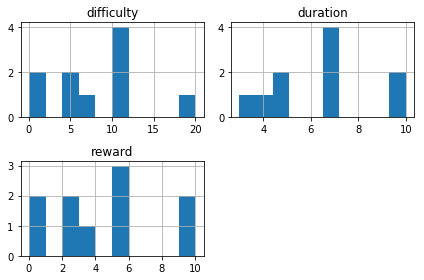

In [86]:
# distribution of portfolio difficulty, reward, and duration
portfolio_clean[['difficulty', 'reward', 'duration']].hist();
plt.tight_layout()

In [9]:
channels = ['web', 'email', 'mobile', 'social']
portfolio_clean.groupby('offer_type').sum()[channels].sum()

web        8
email     10
mobile     9
social     6
dtype: int64

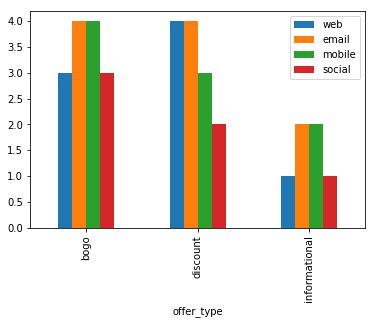

In [7]:
# offer type distribution by channels
channels = ['web', 'email', 'mobile', 'social']
portfolio_clean.groupby('offer_type').sum()[channels].plot(kind='bar')

## 4.2. Profile

In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [40]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


`became_member_on` data type is in int64, we want to parse it to dates.

In [7]:
print(f'There are {profile.shape[0]} profiles in profile dataframe')

There are 17000 profiles in profile dataframe


In [14]:
profile[['age', 'income']].describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


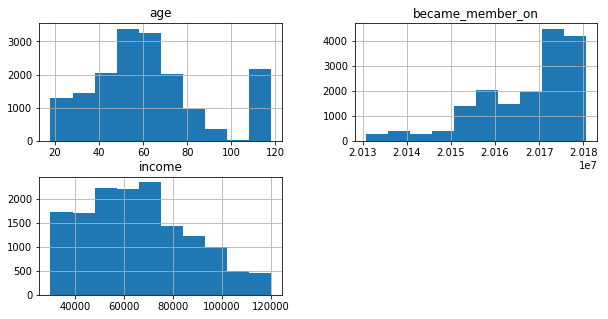

In [16]:
# distribution of age and income column
profile[['age', 'income', 'became_member_on']].hist(figsize=(10,5));


In [18]:
profile[profile.age > 100].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [21]:
profile[profile.age == 118]['age'].value_counts()

118    2175
Name: age, dtype: int64

In [29]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

#### Age & Income Statistics 
- The mean age is 62.53 with standard deviation 26.74
- The mean income is 65405 dollars with standard deviation 21598 dollars
- There were 2175 profiles (12.7%) with age more than 100 years, specifically at 118 age where all missing values in income and gender columns are associated with this profile . This is a **possibility for abnormalities** in the profile data. We will investigate later on whether to remove or keep them.

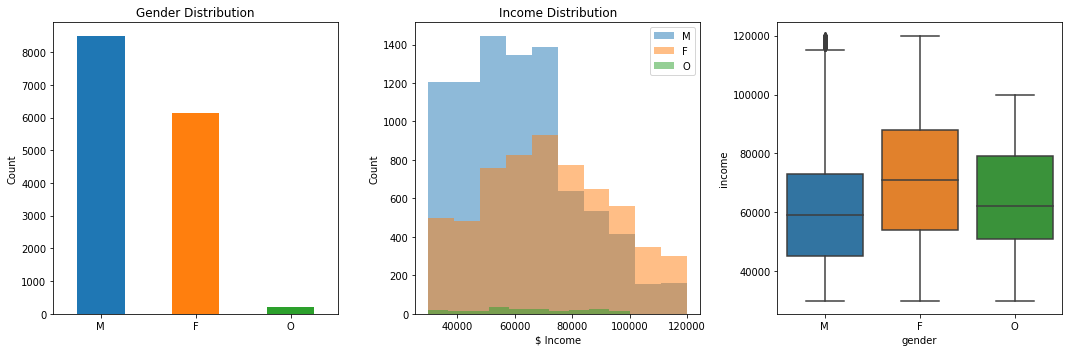

In [8]:
""" GENDER """

f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))

#plot gender distribution histogram
profile.gender.value_counts().plot(kind='bar', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_title('Gender Distribution')
ax1.set_ylabel('Count')

# plot income distribution histogram
ax2.hist(profile[profile.gender == 'M']['income'], alpha=0.5, label='M')
ax2.hist(profile[profile.gender == 'F']['income'], alpha=0.5, label='F')
ax2.hist(profile[profile.gender == 'O']['income'], alpha=0.5, label='O')
ax2.set_xlabel('$ Income')
ax2.set_ylabel('Count')
ax2.set_title('Income Distribution')
ax2.legend()

# boxplot income distribution
sns.boxplot('gender', 'income', data=profile, ax=ax3, order=['M', 'F', 'O'])

plt.tight_layout()


In [28]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [24]:
#statistics income by gender
profile.groupby('gender').describe()['income']

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,6129.0,71306.412139,22338.353773,30000.0,54000.0,71000.0,88000.0,120000.0
M,8484.0,61194.601603,20069.517615,30000.0,45000.0,59000.0,73000.0,120000.0
O,212.0,63287.735849,18938.594726,30000.0,51000.0,62000.0,79250.0,100000.0


#### Gender Statistics
- Most of customers are males (50%) then followed by females (36%), other gender (1.25%), and unknown gender (12.8%). 
- the average income of females (71306 dollars) are higher than males (61194 dollars) and other gender (63287 dollars).
- There are small amount of 'O' / other genders and their income distribution is quite uniform with average income is higher than males.

### 4.2.1 Parsing Dates

In [37]:
#parse dates in became_member_on column

def profile_parse_dates(profile_df):
    profile_df = profile_df.copy()

    #convert to string
    profile_df['became_member_on'] = profile_df.became_member_on.apply(lambda x: str(x))
    #convert to datetime format
    profile_df['became_member_on'] = pd.to_datetime(profile_df.became_member_on)
    return profile_df

profile_clean = profile_parse_dates(profile)

In [156]:
profile_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null datetime64[ns]
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.1+ KB


Text(0.5,1,'Distribution of became_member_on')

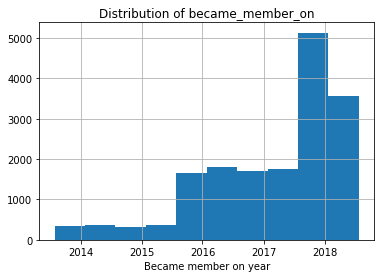

In [32]:
profile_clean.became_member_on.hist()
plt.xlabel('Became member on year')
plt.title('Distribution of became_member_on')

### 4.2.2 Missing Values 

In [97]:
# how much data is missing in each column of profile dataset 
profile_clean.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [98]:
# How much data is missing in each row of profiile  dataset?
row_null = profile_clean.isnull().sum(axis=1)
row_null.value_counts()

0    14825
2     2175
dtype: int64

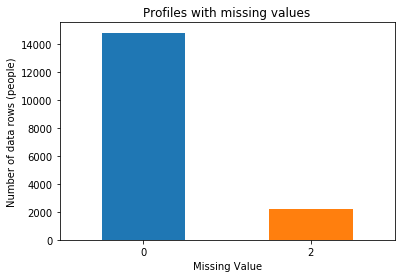

In [99]:
# How much data is missing in each row of profiile  dataset?
row_null = profile_clean.isnull().sum(axis=1)
row_null.value_counts().plot(kind='bar')
plt.xlabel('Missing Value')
plt.xticks(rotation=0)
plt.ylabel('Number of data rows (people)')
plt.title('Profiles with missing values')
plt.show()

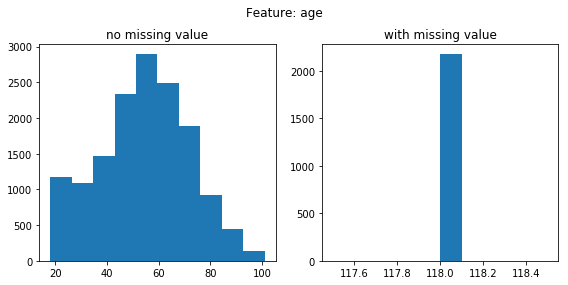

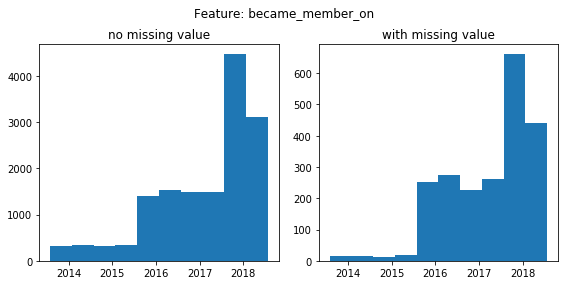

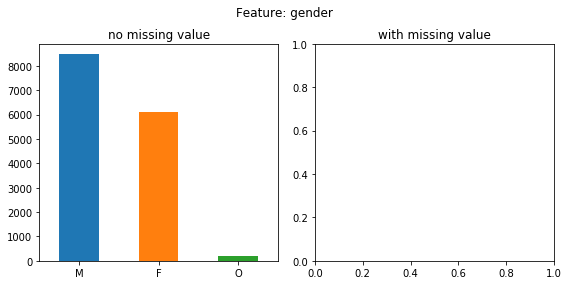

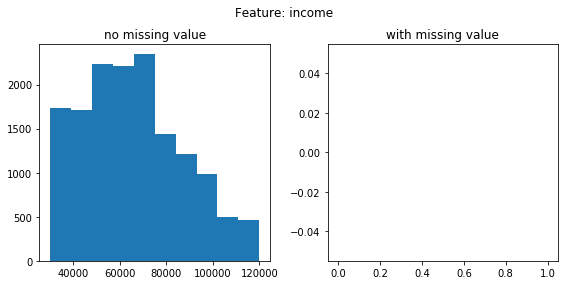

In [102]:
""" Comparing data with no missing value and lot of missing values """

profile_ = profile_clean[row_null ==0]
profile_null = profile_clean[row_null > 0]

for col in ['age', 'became_member_on','gender', 'income' ]:
    row_null = profile_clean.isnull().sum(axis=1)
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
   
    if col == 'gender':
        profile_[col].value_counts().plot(kind='bar', ax=ax1)
        ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(),rotation=0)
        try :
            profile_null[col].value_counts().plot(kind='bar', ax=ax2)
            
        except:
            pass
    else:
        profile_[col].hist(ax=ax1)
        profile_null[col].hist(ax=ax2)
    
    ax1.grid(False)
    ax2.grid(False)
    ax1.set_title('no missing value' )
    ax2.set_title('with missing value')
    f.suptitle('Feature: ' + col)
    f.tight_layout()
    f.subplots_adjust(top=0.85)

#### Profile Data Summary :
1. There were 17000 profiles, 2175 profiles have missing values in gender and income.
2. `became_member_on` data type int64, so It requires to be converted to datetimes data type
3. There were abnormalities in the profile data where the age is 118 years are associated with all missing values in income and gender columns. There about 2175 profiles. Probably they don't want to share the informations or in this a default age number in the app. We will investigate their spending pattern later on to decide whether to remove or keep them.
4. Most of customers are males (50%) then followed by females (36%), other gender (1.25%), and unknown gender (12.8%). However the average income of females (71306 dollars) are higher than males (61194 dollars) and other gender (63287 dollars).

## 4.3. Transcript

In [65]:
print(f'There were {transcript.shape[0]} data in transcript dataset')
transcript.head()

There were 306534 data in transcript dataset


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [15]:
transcript.tail()

,event,person,time,value
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999}
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53}
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [39]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [41]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [67]:
#check for missing value
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [32]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [35]:
# unique profile in transcript match with unique profile in profile data
transcript.person.unique().shape

(17000,)

#### Transcript Data :
- There were 306534 data in transcript dataset
- Most data related to event `transaction`, followed by `offer recevied`, `offer viewed`, and `offer completed`.
- All profiles in profile data is available in transcript data.
- No missing values

### 4.3.1. Transcript Preprocessing

The `value` column consisted of dictionary containing `offer_id` and `amount`. The `offer_id` is related to the `event` of offer received, reviewed, and completed. The `amount` is related to event of transaction.

Therefore, this column will be encoded and added 2 new columns to contains `offer_id` and transaction `amount`. The profile and portfolio dataframe will be join to the transcript dataframe.

In [31]:
""" Encode offer_id and amount in value column """

def encode_offer_id(x):
    try :
        return x['offer id']
    except:
        return x['offer_id']

def transcript_encoded(transcript_df):
    transcript_encoded = transcript_df.copy()
    transcript_encoded['offer_id'] = transcript[transcript.event.isin(['offer received', 'offer viewed', 'offer completed'])]\
                                                             .value.apply(encode_offer_id)
    transcript_encoded['amount'] =  transcript[transcript.event.isin(['transaction'])].value.apply(lambda x: x['amount'])
    return transcript_encoded

transcript_encoded(transcript).head()

,event,person,time,value,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [38]:
""" join profile, portfolio dataset to transcript dataframe """

def merge_transcript_profile(transcript_df, profile_df):
    profile_df = profile_parse_dates(profile_df)
    transcript_encoded_df = transcript_encoded(transcript_df)
    transcript_profile_df = pd.merge(transcript_encoded_df, profile_df, left_on=['person'], 
                                      right_on = ['id'], how ='left')
    transcript_profile_df = transcript_profile_df.drop(['id'], axis=1)
    
    return transcript_profile_df


def merge_transcript_profile_portfolio(transcript_df, profile_df, portfolio_df):
    portfolio_df = portfolio_preprocessing(portfolio_df)
    transcript_profile_df = merge_transcript_profile(transcript_df, profile_df)
    transcript_profile_porto = pd.merge(transcript_profile_df, portfolio_df, left_on = 'offer_id', right_on ='id', how='left').drop('id', axis=1)
    return transcript_profile_porto


transcript_merged = merge_transcript_profile_portfolio(transcript, profile, portfolio)
transcript_merged.head()

,event,person,time,value,offer_id,amount,age,became_member_on,gender,income,difficulty,duration,offer_type,reward,name,web,email,mobile,social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0,5.0,7.0,bogo,5.0,bogo_5_5_7,1.0,1.0,1.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,118,2017-08-04,None,NaN,20.0,10.0,discount,5.0,discount_20_5_10,1.0,1.0,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,68,2018-04-26,M,70000.0,10.0,7.0,discount,2.0,discount_10_2_7,1.0,1.0,1.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,118,2017-09-25,None,NaN,10.0,10.0,discount,2.0,discount_10_2_10,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,118,2017-10-02,None,NaN,10.0,5.0,bogo,10.0,bogo_10_10_5,1.0,1.0,1.0,1.0


### 4.3.2. Event & Offer Type distribution 

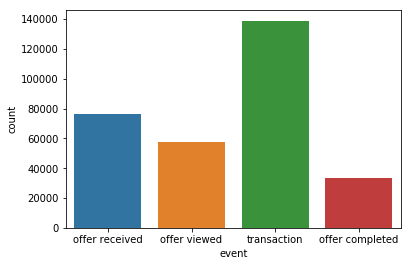

In [34]:
""" the distribution of transcript event type """

sns.countplot('event', data= transcript_merged)

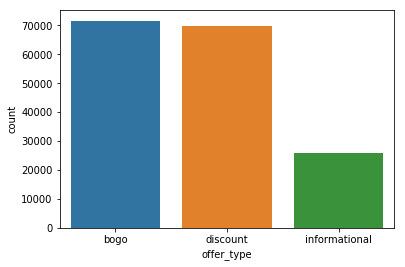

In [9]:
""" offer type distribution """
sns.countplot('offer_type', data= transcript_merged)

Text(0.5,1,'The distribution of offer name sent to customers')

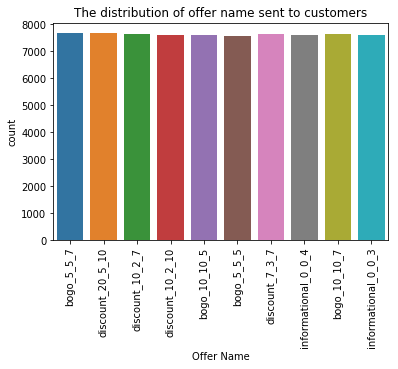

In [36]:
""" The distribuiton of offer sent to customers """

received = transcript_merged[transcript_merged.event =='offer received']

sns.countplot(received['name'])
plt.xlabel('Offer Name')
plt.xticks(rotation=90)
plt.title('The distribution of offer name sent to customers')

The distribution of offer sent by starbucks is uniform.

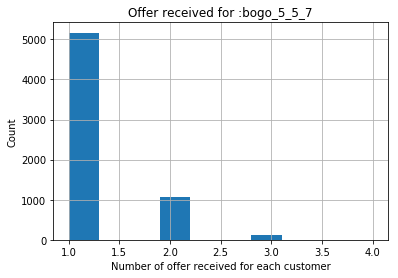

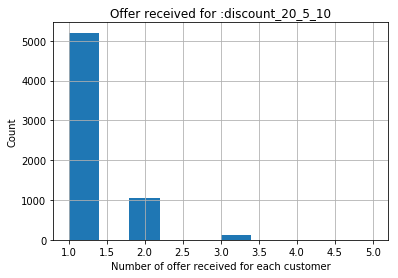

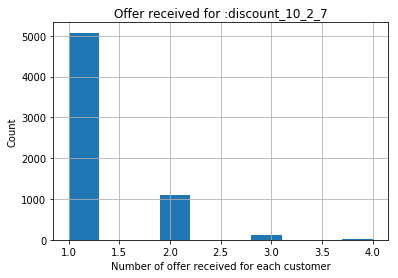

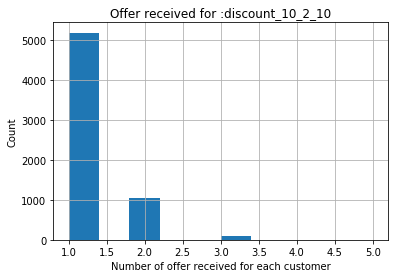

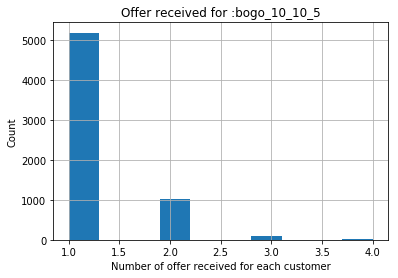

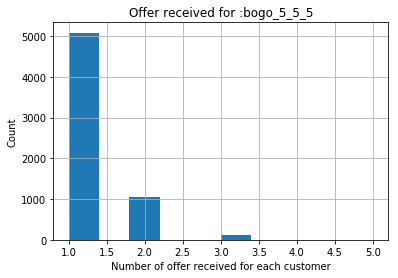

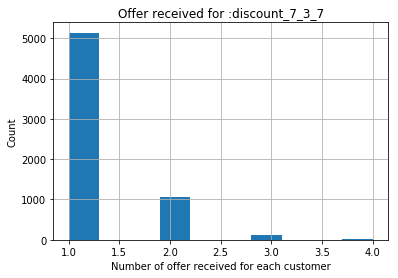

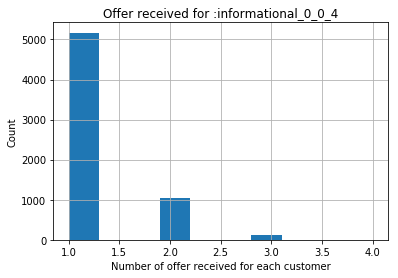

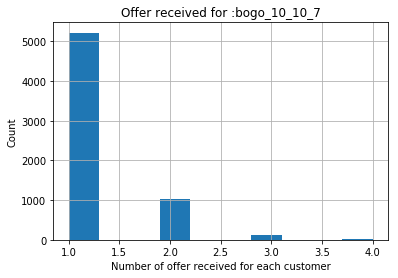

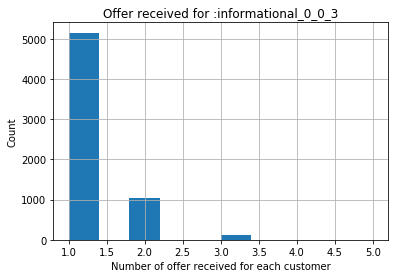

In [254]:
""" The distribution of offer received for each customer (profile) """

for offer_name in received.name.unique():
    received[received.name == offer_name]['person'].value_counts().hist()
    plt.xlabel('Number of offer received for each customer')
    plt.ylabel('Count')
    plt.title('Offer received for :' + offer_name)
    plt.show()

The distribution of offer received by each customer is similar to all offering type. Some customer received more than 1 time for the same offer.

### 4.3.3 Spending and Transaction Count

count    16578.000000
mean        13.680266
std         16.056763
min          0.050000
25%          3.181392
50%         11.996607
75%         20.469643
max        451.470000
Name: amount, dtype: float64

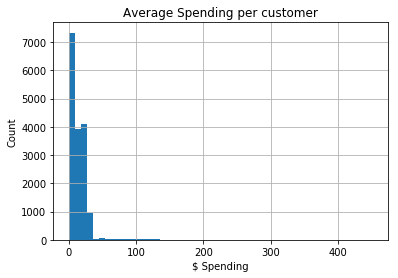

In [18]:
""" Average Spending distribution for each customer """

transcript_merged.groupby('person')['amount'].mean().hist(bins=50)
plt.xlabel('$ Spending')
plt.ylabel('Count')
plt.title('Average Spending per customer')
transcript_merged.groupby('person')['amount'].mean().describe()

count    17000.000000
mean       104.438351
std        125.922619
min          0.000000
25%         21.820000
50%         69.405000
75%        148.782500
max       1608.690000
Name: amount, dtype: float64

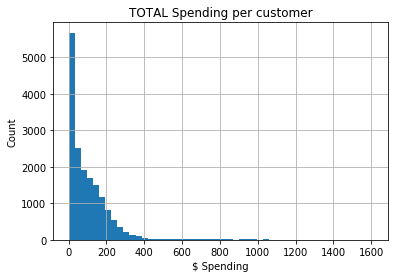

In [30]:
""" Total Spending distribution for each customer """

transcript_merged.groupby('person')['amount'].sum().hist(bins=50)
plt.xlabel('$ Spending')
plt.ylabel('Count')
plt.title('TOTAL Spending per customer')
transcript_merged.groupby('person')['amount'].sum().describe()

count    17000.000000
mean         8.173706
std          5.116250
min          0.000000
25%          4.000000
50%          7.000000
75%         11.000000
max         36.000000
Name: amount, dtype: float64

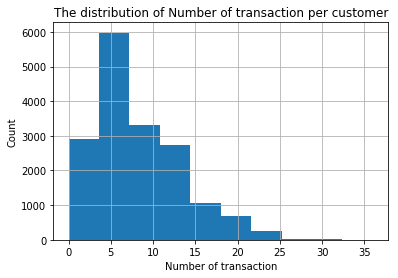

In [31]:
""" The distribution of transaction count for each customer """

transcript_merged.groupby('person')['amount'].count().hist()
plt.xlabel('Number of transaction')
plt.ylabel('Count')
plt.title('The distribution of Number of transaction per customer')
transcript_merged.groupby(['person')['amount'].count().describe()

Text(0.5,0,'gender')

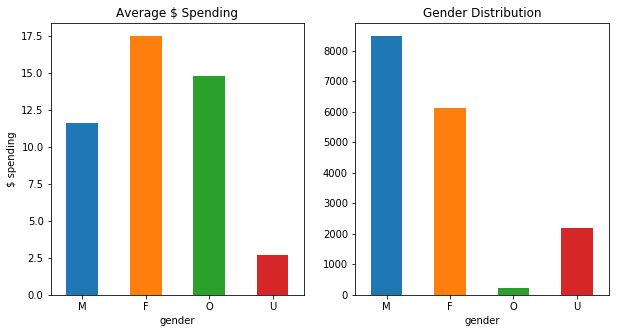

In [11]:
""" Average spending by GENDER """

# assign missing value in gender with 'U' value
transcript_merged_ = transcript_merged.copy()
transcript_merged_.loc[transcript_merged.gender.isnull(), 'gender'] ='U'

#plot
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

#plot average spending
transcript_merged_.groupby('gender')['amount'].mean()[['M', 'F', 'O', 'U']].plot(kind='bar', ax=ax1);
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_ylabel("$ spending")
ax1.set_title("Average $ Spending");

#plot gender distribution
profile.fillna('U').gender.value_counts()[['M', 'F', 'O', 'U']].plot(kind='bar', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
plt.title('Gender Distribution');
ax2.set_xlabel('gender')

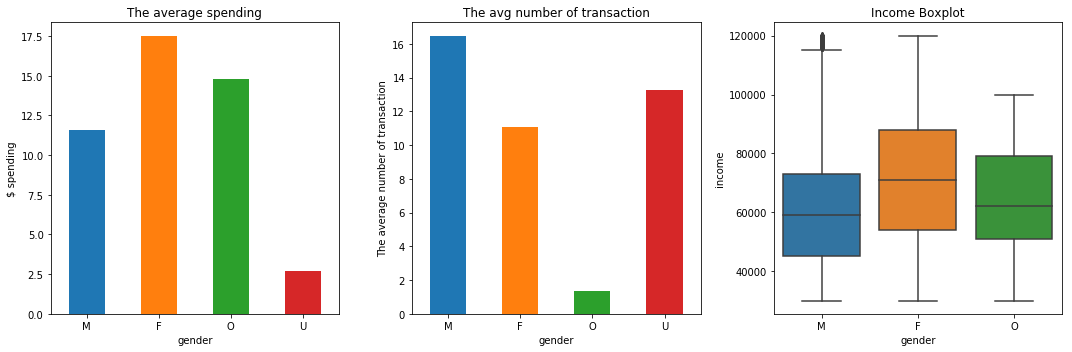

In [149]:
""" The number of transaction by GENDER """

#plot avg spending
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
transcript_merged_.groupby('gender')['amount'].mean()[['M', 'F', 'O', 'U']].plot(kind='bar', ax=ax1);
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_ylabel("$ spending")
ax1.set_title('The average spending')

# plot avg number of transaction

transcript_merged_.groupby(['gender', 'amount'])['amount'].count().mean(level=0)[['M', 'F', 'O', 'U']].plot(kind='bar', ax=ax2);
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=0);
ax2.set_ylabel("The average number of transaction");
ax2.set_title("The avg number of transaction");

# boxplot income distribution
sns.boxplot('gender', 'income', data=profile, ax=ax3, order=['M', 'F', 'O'])
ax3.set_title('Income Boxplot')

plt.tight_layout()


The highest average spending is made by females while customer with gender 'O' /other gender is the second highest despite there are only few of them and also only made few transactions. 

The average spending is correlated with income. The higher the income, the higher the average spending is.

The unknown / 'U' gender is the lowest average spending, however they made higher number of transactions than females and others. It may indicate they are a different customer types / demographis and should be assessed separately rather than remove them from dataset. 

### 4.3.4 Offer Received, Viewed and Completed

Text(0.5,1,'Portfolio Distribution by Event')

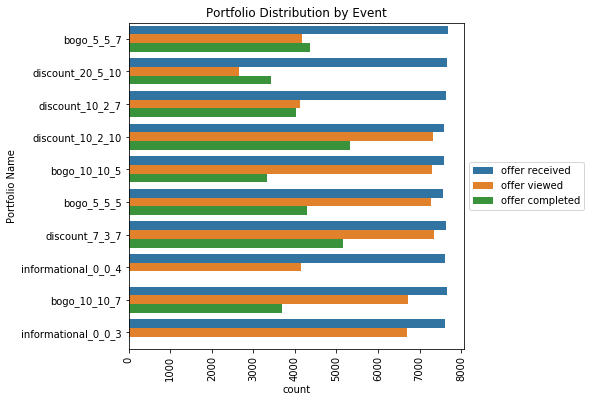

In [152]:
"""
Portfolio Distribution by event
"""

plt.figure(figsize=(6,6))
sns.countplot(y='name', hue='event', data=transcript_merged[~transcript_merged.event.isin(['transaction'])]);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.ylabel("Portfolio Name")
plt.title("Portfolio Distribution by Event")

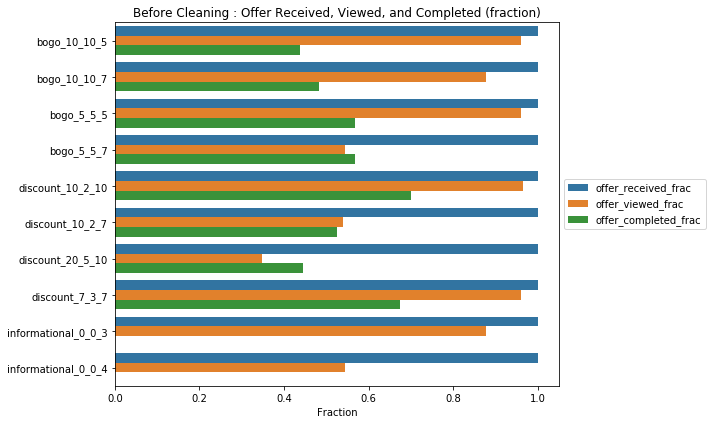

In [185]:
""" Portfolio Distribution by event in Fraction """

event_count = transcript_merged[~transcript_merged.event.isin(['transaction'])].groupby(['name', 'event']).size().unstack()
event_count['offer_received_frac'] = event_count['offer received']/ event_count['offer received']
event_count['offer_viewed_frac'] = event_count['offer viewed']/ event_count['offer received']
event_count['offer_completed_frac'] =  event_count['offer completed']/ event_count['offer received']

event_count_frac = event_count[['offer_received_frac','offer_viewed_frac', 'offer_completed_frac']]

event_count_stack = event_count_frac.stack().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x=0,y='name', hue='event', data=event_count_stack)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(top=0.8)
plt.title("Before Cleaning : Offer Received, Viewed, and Completed (fraction)")
plt.ylabel('')
plt.xlabel('Fraction')

plt.tight_layout()

### Abnormalities in transcript data :
From the figure above, `Bogo 5_5_7` and `Discount_20_5_10` appeared to have higher offer completed than offer viewed. It means that the transaction was not due to the offer and requires  to be cleaned out or separate  for further analysis. 

### 4.3.5 Transcript Data cleaning 

The transcript need to be cleaned so it only contained the transcript that was influenced by the offer. There are several transactions that customers commit when they do not opt into the offer, in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

The offer is completed or valid when the customer received, viewed, and make transaction to completed the offer, otherwise the offer completed is not valid. It is true for discounts and bogos. While for informational offer, there is no offer completed.

A cleaning function of `transcript_preprocessing` is created in another file `helpers.py` that will clean all invalid transaction. The function takes `transcript`, `profile` and `portfolio` dataframe and return `transcript_clean` dataframe and `transcript_all` dataframe. The `transcript_clean` dataframe contains only a valid offer completed. The `transcript_all` dataframe contains all transcript as the same of the input with additional columns of `invalid` to mark where the offer completed is invalid 


This is the core alogrithm to find the invalid offer completed

```
def find_invalid_index(transcript_df, profile_df, portfolio_df):
    """
    INPUT : transcript, profile, portfolio dataframe
    RETURN : a list of invalid index in transcript dataframe
    """
    
    #merge transcript, profile and portfolio dataframe
    trascript_merge_df = merge_transcript_profile_portfolio(transcript_df, profile_df, portfolio_df)

    # list of invalid index of offer completed
    invalid_index = []

    #iterate over profile_id (person)
    for profile_id in tqdm(trascript_merge_df.person.unique()):
        # take a subest_df for profile_id person
        subset_df = trascript_merge_df[trascript_merge_df.person == profile_id]
        # take a subset of 'offer completed'
        completed_df = subset_df[subset_df.event == 'offer completed']

        # iterate over the completed offer_id
        for offer in completed_df.offer_id.unique():
            # take a subset df of completed offer
            comp = completed_df[completed_df.offer_id == offer]
            # estimate the offer received time in hours using the offer duration (in days)
            start_time = comp.time.values - (comp.duration.values *24)
            # the offer completed time
            comp_time = comp.time.values
            # take the subset within start_time and comp_time
            subset = subset_df[(subset_df.time >= start_time[0]) & (subset_df.time <= comp.time.values[0])]
            # take only event of offer viewed for the given offer_id
            subset_viewed = subset[(subset.event == 'offer viewed') & ( subset.offer_id == offer)]

            # check whether subset_viewed is empty or not, if it is empty then the offer completed is not valid
            # because the offer is completed before the customer viewed it,
            # it means  that the customer was not affected by the portfolio campaign
            if subset_viewed.shape[0] == 0 :
                invalid_index.extend(comp.index)

    return invalid_index
```

In [19]:
%load_ext autoreload
%autoreload 2
import helpers as h

# re-read read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [20]:
transcript_clean, transcript_all = h.transcript_preprocessing(transcript, profile, portfolio)

The transcript_clean.csv and transcript_merge.csv file are available at local folder


In [21]:
transcript_clean.head()

,event,person,time,value,offer_id,amount,age,became_member_on,gender,income,difficulty,duration,offer_type,reward,name,web,email,mobile,social,invalid
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0,5.0,7.0,bogo,5.0,bogo_5_5_7,1.0,1.0,1.0,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,118,2017-08-04,NaN,NaN,20.0,10.0,discount,5.0,discount_20_5_10,1.0,1.0,0.0,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,68,2018-04-26,M,70000.0,10.0,7.0,discount,2.0,discount_10_2_7,1.0,1.0,1.0,0.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,118,2017-09-25,NaN,NaN,10.0,10.0,discount,2.0,discount_10_2_10,1.0,1.0,1.0,1.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,118,2017-10-02,NaN,NaN,10.0,5.0,bogo,10.0,bogo_10_10_5,1.0,1.0,1.0,1.0,0.0


In [22]:
transcript_all.head()

,event,person,time,value,offer_id,amount,age,became_member_on,gender,income,difficulty,duration,offer_type,reward,name,web,email,mobile,social,invalid
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0,5.0,7.0,bogo,5.0,bogo_5_5_7,1.0,1.0,1.0,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,118,2017-08-04,NaN,NaN,20.0,10.0,discount,5.0,discount_20_5_10,1.0,1.0,0.0,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,68,2018-04-26,M,70000.0,10.0,7.0,discount,2.0,discount_10_2_7,1.0,1.0,1.0,0.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,118,2017-09-25,NaN,NaN,10.0,10.0,discount,2.0,discount_10_2_10,1.0,1.0,1.0,1.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,118,2017-10-02,NaN,NaN,10.0,5.0,bogo,10.0,bogo_10_10_5,1.0,1.0,1.0,1.0,0.0


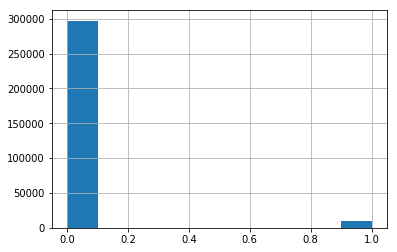

In [25]:
transcript_all.invalid.hist()

### 4.3.6 Visualize Offer Received, Viewed, and Completed

In [240]:
event_count = transcript_clean.groupby(['name', 'offer_type','event']).size().unstack()
event_count['offer_received_frac'] = event_count['offer received']/ event_count['offer received']
event_count['offer_viewed_frac'] = event_count['offer viewed']/ event_count['offer received']
event_count['offer_completed_frac'] =  event_count['offer completed']/ event_count['offer received']

event_count_frac = event_count[['offer_received_frac','offer_viewed_frac', 'offer_completed_frac']]
event_count_frac.reset_index()

event,name,offer_type,offer_received_frac,offer_viewed_frac,offer_completed_frac
0,bogo_10_10_5,bogo,1.0,0.961148,0.369946
1,bogo_10_10_7,bogo,1.0,0.876991,0.352964
2,bogo_5_5_5,bogo,1.0,0.959451,0.471536
3,bogo_5_5_7,bogo,1.0,0.543311,0.287091
4,discount_10_2_10,discount,1.0,0.964460,0.623404
5,discount_10_2_7,discount,1.0,0.539570,0.288391
6,discount_20_5_10,discount,1.0,0.347287,0.184924
7,discount_7_3_7,discount,1.0,0.959587,0.583442
8,informational_0_0_3,informational,1.0,0.877789,NaN
9,informational_0_0_4,informational,1.0,0.544046,NaN


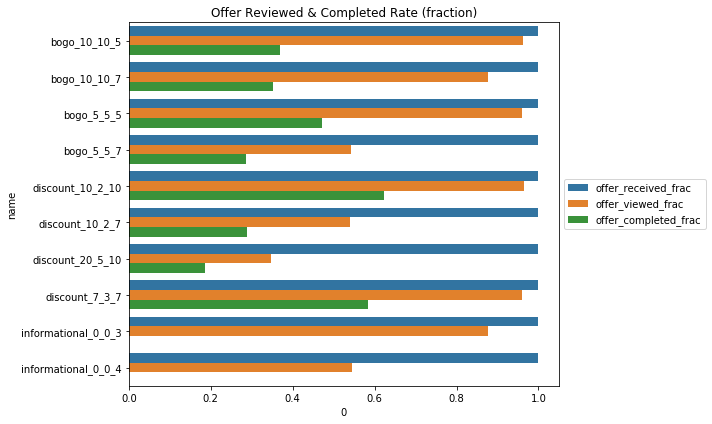

In [236]:
event_count_stack = event_count_frac.stack().reset_index()

f, (ax1, ax2) = plt.subplots(1,2)
plt.figure(figsize=(10,6))
sns.barplot(x=0,y='name', hue='event', data=event_count_stack)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(top=0.8)
plt.title("Offer Reviewed & Completed Rate (fraction)")

plt.tight_layout()

Notice that there is no offer with the `offer_completed` fraction is larger than `offer_viewed` as in before cleaning.

## Which offer type has the higher viewed and completed rate ?

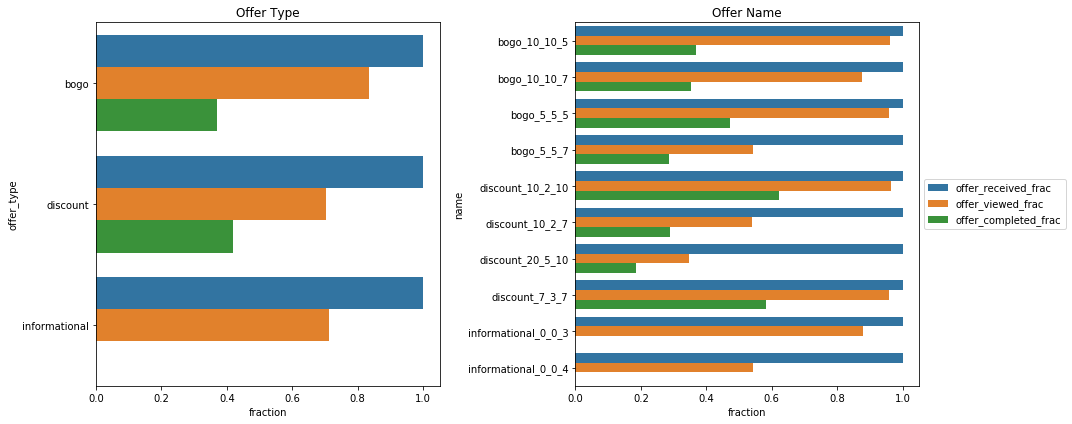

In [253]:
event_count_stack = event_count_frac.stack().reset_index()

f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

# plot offer type

sns.barplot(x=0,y='offer_type', hue='event', data=event_count_stack, ci=None, ax=ax1)
ax1.legend().set_visible(False)
ax1.set_title("Offer Type")
ax1.set_xlabel('fraction')

# plot offer name
sns.barplot(x=0,y='name', hue='event', data=event_count_stack, ax=ax2)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.set_title("Offer Name")
ax2.set_xlabel('fraction')


#plt.subplots_adjust(top=0.8)
plt.tight_layout()

**Which offer type has the higher viewed and completed rate ?**
- The highest reviewed rate is discount_7_3_7, followed by discout_10_2_10
- The highest completed rate is discount_10_2_10, followed by discount_7_3_7
- Most offer viewed rate is bogos, while most offer completed is discount


## 4.4. Feature Extraction from clean transcript, profile, and portfolio

Function of `feature_extraction` is created in `helpers.py` to extract features from `transcript`, `profile` and `portfolio` clean dataframe and return a clean `profile_udpated` dataframe that contains 92 features :
- `age`
- `became_member_on`
- `gender`
- `income`
- Offer received count by each customer for each offer ids
    - `offer received_bogo_5_5_5`
    - `offer received_bogo_5_5_7`
    - `offer received_bogo_10_10_7`
    - `offer received_bogo_10_10_5`
    - `offer received_discount_7_3_7`
    - `offer received_discount_10_2_10`
    - `offer received_discount_10_2_7`
    - `offer received_discount_20_5_10`
    - `offer received_informational_0_0_3`
    - `offer received_informational_0_0_4`
- Offer viewed count by each customer for each offer ids : 
    - `offer viewed_bogo_5_5_5`
    - `offer viewed_bogo_5_5_7`
    - `offer viewed_bogo_10_10_7`
    - `offer viewed_bogo_10_10_5`
    - `offer viewed_discount_7_3_7`
    - `offer viewed_discount_10_2_10`
    - `offer viewed_discount_10_2_7`
    - `offer viewed_discount_20_5_10`
    - `offer viewed_informational_0_0_3`
    - `offer viewed_informational_0_0_4`
    
- Offer completed count by each customer for each offer ids : 
    - `offer completed_bogo_5_5_5`
    - `offer completed_bogo_5_5_7`
    - `offer completed_bogo_10_10_7`
    - `offer completed_bogo_10_10_5`
    - `offer completed_discount_7_3_7`
    - `offer completed_discount_10_2_10`
    - `offer completed_discount_10_2_7`
    - `offer completed_discount_20_5_10`
    - `offer completed_informational_0_0_3`
    - `offer completed_informational_0_0_4`
- Average Response time to completed each offer ids (except informational)
    - `bogo_10_10_7_response_time_avg`
    - `bogo_10_10_5_response_time_avg`
    - `bogo_5_5_7_response_time_avg`
    - `discount_20_5_10_response_time_avg`
    - `discount_7_3_7_response_time_avg`
    - `discount_10_2_10_response_time_avg`
    - `bogo_5_5_5_response_time_avg`
    - `discount_10_2_7_response_time_avg`
- `avg_spending` : average spending made by each customer
- `transaction_count` : total transactions count made by each customer
- `sum_spending` : total amount of transactions made by each customer
- Total count for all offer :
    - `offer_received_total`
    - `offer_viewed_total`
    - `offer_completed_total`
- Total count for all bogo :
    - `bogo_received`
    - `bogo_viewed`
    - `bogo_completed`
- Total count for all discount :
    - `discount_received`
    - `discount_viewed`
    - `discount_completed`
- Total count for all informational :
    - `informational_received`
    - `informational_viewed`  
- Overall rate_offer :
    - `rate_offer_viewed_overall` = `offer_viewed_total` / `offer_received_total`
    - `rate_offer_completed_received_overall` = `offer_completed_total` / `offer_received_total`
    - `rate_offer_completed_viewed_overall` = `offer_completed_total` / `offer_viewed_total`
- All Bogo rate :  
    - `rate_viewed_bogo`
    - `rate_completed_viewed_bogo`
    - `rate_completed_received_bogo`
- All Discount rate :  
    - `rate_viewed_discount`
    - `rate_completed_viewed_discount`
    - `rate_completed_received_discount`
- All Informational rate :  
    - `rate_viewed_informational`
- Rate offer for each offer :
    - `rate_offer_viewed_bogo_10_10_7`
    - `rate_offer_completed_viewed_bogo_10_10_7`
    - `rate_offer_completed_received_bogo_10_10_7`
    - `rate_offer_viewed_bogo_10_10_5`
    - `rate_offer_completed_viewed_bogo_10_10_5`
    - `rate_offer_completed_received_bogo_10_10_5`
    - `rate_offer_viewed_informational_0_0_4`
    - `rate_offer_viewed_bogo_5_5_7`
    - `rate_offer_completed_viewed_bogo_5_5_7`
    - `rate_offer_completed_received_bogo_5_5_7`
    - `rate_offer_viewed_discount_20_5_10`
    - `rate_offer_completed_viewed_discount_20_5_10`
    - `rate_offer_completed_received_discount_20_5_10`
    - `rate_offer_viewed_discount_7_3_7`
    - `rate_offer_completed_viewed_discount_7_3_7`
    - `rate_offer_completed_received_discount_7_3_7`
    - `rate_offer_viewed_discount_10_2_10`
    - `rate_offer_completed_viewed_discount_10_2_10`
    - `rate_offer_completed_received_discount_10_2_10`
    - `rate_offer_viewed_informational_0_0_3`
    - `rate_offer_viewed_bogo_5_5_5`
    - `rate_offer_completed_viewed_bogo_5_5_5`
    - `rate_offer_completed_received_bogo_5_5_5`
    - `rate_offer_viewed_discount_10_2_7`
    - `rate_offer_completed_viewed_discount_10_2_7`
    - `rate_offer_completed_received_discount_10_2_7`
- `transaction_completed_ratio` : `transaction_count` / `offer_completed_total`

In [3]:

%load_ext autoreload
%autoreload 2

import helpers as h

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#clean transcript
transcript_clean, transcript_all = h.transcript_preprocessing(transcript, profile, portfolio)

#extract features
profile_updated = h.feature_extraction(transcript_clean,transcript_all,profile, portfolio)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The transcript_clean.csv and transcript_merge.csv file are available at local folder
The profile_updated.csv file is available at local folder.


In [5]:
profile_updated.shape

(17000, 92)

In [8]:
profile_updated.head()

,age,became_member_on,gender,income,offer received_bogo_10_10_7,offer received_bogo_10_10_5,offer received_informational_0_0_4,offer received_bogo_5_5_7,offer received_discount_20_5_10,offer received_discount_7_3_7,...,rate_offer_completed_viewed_discount_10_2_10,rate_offer_completed_received_discount_10_2_10,rate_offer_viewed_informational_0_0_3,rate_offer_viewed_bogo_5_5_5,rate_offer_completed_viewed_bogo_5_5_5,rate_offer_completed_received_bogo_5_5_5,rate_offer_viewed_discount_10_2_7,rate_offer_completed_viewed_discount_10_2_7,rate_offer_completed_received_discount_10_2_7,transaction_completed_ratio
68be06ca386d4c31939f3a4f0e3dd783,118,2017-02-12,None,NaN,0.0,0.0,0.0,0.0,1.0,1.0,...,0.5,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.285714
0610b486422d4921ae7d2bf64640c50b,55,2017-07-15,F,112000.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.000000
38fe809add3b4fcf9315a9694bb96ff5,118,2018-07-12,None,NaN,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,60.000000
78afa995795e4d85b5d9ceeca43f5fef,75,2017-05-09,F,100000.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.333333
a03223e636434f42ac4c3df47e8bac43,118,2017-08-04,None,NaN,0.0,0.0,1.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.000000


In [9]:
profile_updated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, 68be06ca386d4c31939f3a4f0e3dd783 to e4052622e5ba45a8b96b59aba68cf068
Data columns (total 92 columns):
age                                               17000 non-null int64
became_member_on                                  17000 non-null datetime64[ns]
gender                                            14825 non-null object
income                                            14825 non-null float64
offer received_bogo_10_10_7                       17000 non-null float64
offer received_bogo_10_10_5                       17000 non-null float64
offer received_informational_0_0_4                17000 non-null float64
offer received_bogo_5_5_7                         17000 non-null float64
offer received_discount_20_5_10                   17000 non-null float64
offer received_discount_7_3_7                     17000 non-null float64
offer received_discount_10_2_10                   17000 non-null float64
offer received_informational_0_